In [1]:
# prediction model
# win probability
# ball weight, player-performence estimation, recent performence trend etc

In [2]:
from math import erf, sqrt, inf

import os
import datetime
import numpy as np
import csv
import pickle
from matplotlib import pyplot as plt 
import statistics 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import math

import statsmodels.api as sm
import scipy

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# import tensorflow as tf
import joblib

In [3]:
#matches1st5yrs

In [4]:
with open('dataofallmatchesinfirstfiveyears.pkl', 'rb') as file: 
    unpickler = pickle.Unpickler(file)
    matches1st5yrs = unpickler.load() 
    file.close()
    
inningsTotals=[]
for matchNo in range(len(matches1st5yrs)):
    ballKeys=list(matches1st5yrs[matchNo]['ourData'].keys())
    ballKeys.sort(reverse=True)
    totalRunInInnings=matches1st5yrs[matchNo]['ourData'][ballKeys[-1]]['totalrunscount']
    inningsTotals.append(totalRunInInnings)
    
def getWickRemCategorical(w):
    x=[0]*11
    x[w]=1
    return x

def getXYdata(ballRemType,wickRemType):
    XYdata={}
    if ballRemType=='ballRemAsFeature':
        XYdata['X'],XYdata['Y']=[],[]
    for matchNo in range(len(matches1st5yrs)):
        totalRunThisMatch=inningsTotals[matchNo]

        ballRem=list(matches1st5yrs[matchNo]['ourData'].keys())
        ballRem.sort(reverse=True)

        for b in ballRem:
            thiswicketsremaining=matches1st5yrs[matchNo]['ourData'][b]['wicketsremaining']
            thisBallRun=matches1st5yrs[matchNo]['ourData'][b]['totalrunscount']
            
            if ballRemType=='ballByBallDict':
                if XYdata.get(b)is None: # for ballByBallDict
                    XYdata[b]={}
                    XYdata[b]['X']=[]
                    XYdata[b]['Y']=[]
                XYdata[b]['Y'].append(totalRunThisMatch-thisBallRun)
            elif ballRemType=='ballRemAsFeature':
                XYdata['Y'].append(totalRunThisMatch-thisBallRun)
                
            if wickRemType=='cat':
                x=getWickRemCategorical(thiswicketsremaining)
            elif wickRemType=='num':
#                 x=[sum(W[10-thiswicketsremaining:])] # weighted wicket-rem
                x=[thiswicketsremaining] # weighted wicket-rem
    
#             x.append(thisBallRun)

            if ballRemType=='ballRemAsFeature':
                x.append(b)
                
            if ballRemType=='ballByBallDict':
                XYdata[b]['X'].append(x)
            elif ballRemType=='ballRemAsFeature':
                XYdata['X'].append(x)
    return XYdata
XYdata=getXYdata('ballByBallDict','cat')

In [5]:
fitModel={}
for j in range(120):
    ConstAdded=sm.add_constant(XYdata[j]['X'])
    model = sm.OLS(XYdata[j]['Y'],ConstAdded)
    fitModel[j]=model.fit()  #.fit(cov_type='cluster')  

joblib.dump(fitModel,'ols1stInngs.z')

['ols1stInngs.z']

In [6]:
fitModel[j].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.03116
Date:                Tue, 21 Sep 2021   Prob (F-statistic):              0.860
Time:                        17:59:00   Log-Likelihood:                -1537.6
No. Observations:                 319   AIC:                             3079.
Df Residuals:                     317   BIC:                             3087.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.0078      2.742     37.934      0.000      98.613     109.402
x1          6.721e-15   7.33e-16      9.164      0.000    5.28e-15    8.16e-15
x2                  0          0        nan        nan           0           0
x3                  0          0        nan        nan           0           0
x4                  0          0        nan        nan           0           0
x5                  0          0        nan        nan           0           0
x6                  0          0        nan        nan           0           0
x7                  0          0        nan        nan           0           0
x8                  0          0        nan        nan           0           0
x9                  0          0        nan        nan           0           0
x10           51.2779      5.393      9.509      0.000      40.668      61.888
x11           52.7299      2.917     18.078      0.000      46.991      58.469
==============================================================================
Omnibus:                        0.522   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.770   Jarque-Bera (JB):                0.389
Skew:                          -0.081   Prob(JB):                        0.823
Kurtosis:                       3.056   Cond. No.                     3.51e+87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5e-173. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [7]:
fitModel=joblib.load('ols1stInngs.z')

def getWickRemCategorical(w):
    x=[0]*11
    x[w]=1
    return x
def get_OLS_ballByBallDict_catWickRem(ballRem=119,wicketRem=10):
    x=getWickRemCategorical(wicketRem)
    x.insert(0,1)
    return round(fitModel[ballRem].predict(x)[0],0)

In [8]:
# MU,SIGMA={},{} 
# for b in range(120):
#     errorsThisBall=[]
#     for matchNo in range(len(matches1st5yrs)):
#         actualTotalRun=inningsTotals[matchNo]

#         ballRem=list(matches1st5yrs[matchNo]['ourData'].keys())
#         ballRem.sort(reverse=True)
#         try:
#             thiswicketsremaining=matches1st5yrs[matchNo]['ourData'][b]['wicketsremaining']
#             thisBallRun=matches1st5yrs[matchNo]['ourData'][b]['totalrunscount']
#             predictedTotalRun=thisBallRun+get_OLS_ballByBallDict_catWickRem(ballRem=b,wicketRem=thiswicketsremaining)
#             errorsThisBall.append(predictedTotalRun-actualTotalRun)
#         except:
#             None

#     MU[b]=np.mean(errorsThisBall)
#     SIGMA[b]=np.std(errorsThisBall)

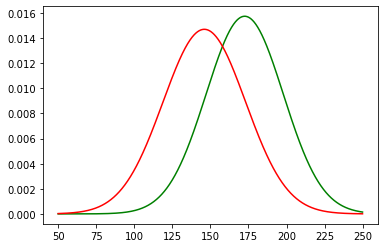

In [9]:
with open('allMatchesBallByBall.pkl', 'rb') as file: 
    unpickler = pickle.Unpickler(file)
    allMatchesBallByBall = unpickler.load() 
    file.close()

firstBatWinningRuns,firstBatLosingRuns=[],[]

for match in range(len(allMatchesBallByBall)):
    if allMatchesBallByBall[match]['matchDate'].year>2012:
        continue
    totalRun=0
    for ballInfo in allMatchesBallByBall[match]['innings'][0]:
        ballKey=list(ballInfo.keys())[0]
        totalRun+=ballInfo[ballKey]['runs']['total']
    try:
        if (allMatchesBallByBall[match]['teams'][0]==allMatchesBallByBall[match]['winner']):
            firstBatWinningRuns.append(totalRun)
        else:
            firstBatLosingRuns.append(totalRun)
    except:
        None

mu1,sig1,mu2,sig2=np.mean(firstBatWinningRuns),np.std(firstBatWinningRuns),np.mean(firstBatLosingRuns),np.std(firstBatLosingRuns)
winDistribution= scipy. stats. norm(mu1, sig1)
lossDistribution=scipy. stats. norm(mu2, sig2)

joblib.dump([winDistribution,lossDistribution],'winLossDistribution1stInngs.z')

x_values = np. arange(50, 250, 0.1)
plt. plot(x_values, winDistribution. pdf(x_values),color='g')
plt. plot(x_values, lossDistribution. pdf(x_values),color='r')
plt.show()

def getWinProb(run):
    return round((winDistribution.pdf(run)/(winDistribution.pdf(run)+lossDistribution.pdf(run)))*100,1)

In [10]:
def generateWinProbPlot(balls,winP,overEndBalls,overEndWinProbs,xtickList):
    fig=plt.figure(figsize=(25,10))
    ax1 = fig.add_subplot(111)
    ax1.plot(balls,winP)
    ax1.scatter(overEndBalls,overEndWinProbs,marker='$o$',color='black')
    for i, txt in enumerate(overEndWinProbs):
        if txt<85:
            ax1.annotate(txt, (overEndBalls[i]-1, overEndWinProbs[i]+1),weight='bold',size=12,rotation=45)
        else:
            ax1.annotate(txt, (overEndBalls[i]-1, overEndWinProbs[i]-5),weight='bold',size=12,rotation=45)

    ax1.set_yticks(np.arange(0,101,10))
    ax1.set_xticks(np.arange(0,121,6))
    ax1.set_xticklabels(xtickList,rotation=90)
    plt.grid()
    plt.show()

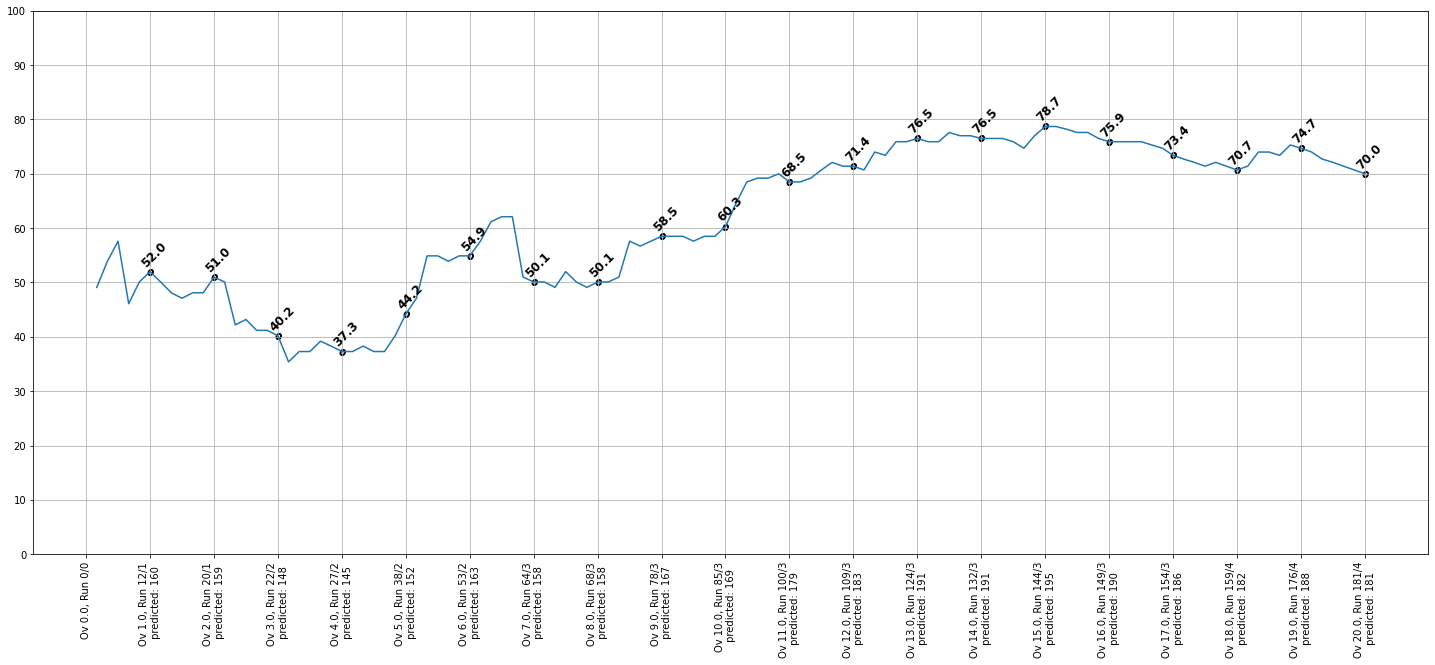

In [11]:
match=30
ballKeys=list(matches1st5yrs[match]['ourData'].keys())
ballKeys.sort(reverse=True)
c=1
winP,balls=[],[]
overEndBalls,overEndWinProbs=[],[]
xtickList=['Ov 0.0, Run 0/0']
for b in ballKeys:
    runScored=matches1st5yrs[match]['ourData'][b]['totalrunscount']
    wicktRem=matches1st5yrs[match]['ourData'][b]['wicketsremaining']
    predicted=runScored+get_OLS_ballByBallDict_catWickRem(ballRem=b,wicketRem=wicktRem)
    winProb=getWinProb(predicted)
    
    if b%6==0:
        thisTick='Ov '+str(int((120-b)/6))+'.'+str((120-b)%6)+', Run '+str(runScored)+'/'+str(10-wicktRem)
        thisTick+='\n predicted: '+str(int(predicted))
        xtickList.append(thisTick)
        
        overEndBalls.append(120-b)
        overEndWinProbs.append(winProb)
        
#     print(b,round(1/(1+np.exp((midRun-predicted)*c)))*100,2)
    winP.append(winProb)
    balls.append(120-b)

generateWinProbPlot(balls,winP,overEndBalls,overEndWinProbs,xtickList)

In [12]:
totalRuns={}
for b in range(120):
    totalRuns[b]=0
for match in matches1st5yrs:
    for ball in match['ourData']:
        try: 
            totalRuns[ball]+= match['ourData'][ball]['totalrunscount']
        except:
            None
ballweight={}
for b in range(120):
    ballweight[b]=totalRuns[b]/totalRuns[0]

In [13]:
print(matches1st5yrs[50])

{'ourData': {119: {'totalrunscount': 0, 'wicketsremaining': 10}, 118: {'totalrunscount': 2, 'wicketsremaining': 10}, 117: {'totalrunscount': 3, 'wicketsremaining': 10}, 116: {'totalrunscount': 4, 'wicketsremaining': 10}, 115: {'totalrunscount': 4, 'wicketsremaining': 10}, 114: {'totalrunscount': 5, 'wicketsremaining': 10}, 113: {'totalrunscount': 5, 'wicketsremaining': 10}, 112: {'totalrunscount': 9, 'wicketsremaining': 10}, 111: {'totalrunscount': 10, 'wicketsremaining': 10}, 110: {'totalrunscount': 11, 'wicketsremaining': 10}, 109: {'totalrunscount': 20, 'wicketsremaining': 10}, 108: {'totalrunscount': 21, 'wicketsremaining': 10}, 107: {'totalrunscount': 22, 'wicketsremaining': 10}, 106: {'totalrunscount': 22, 'wicketsremaining': 10}, 105: {'totalrunscount': 22, 'wicketsremaining': 10}, 104: {'totalrunscount': 22, 'wicketsremaining': 10}, 103: {'totalrunscount': 23, 'wicketsremaining': 10}, 102: {'totalrunscount': 24, 'wicketsremaining': 10}, 101: {'totalrunscount': 24, 'wicketsremai

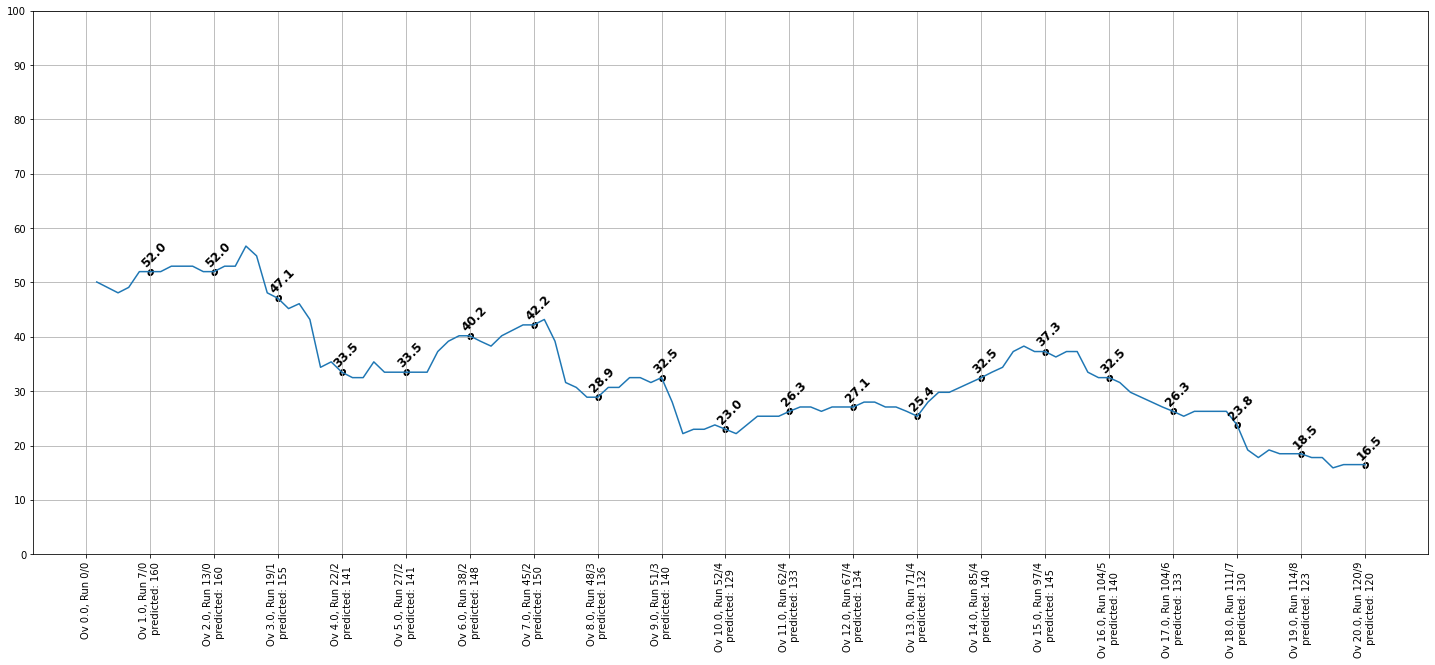

In [14]:
match=100
ballKeys=list(matches1st5yrs[match]['ourData'].keys())
ballKeys.sort(reverse=True)
c=1
winP,balls=[],[]
overEndBalls,overEndWinProbs=[],[]
xtickList=['Ov 0.0, Run 0/0']
lastBallPredicted=round(np.mean(firstBatWinningRuns+firstBatLosingRuns),0)
for b in ballKeys:
    runScored=matches1st5yrs[match]['ourData'][b]['totalrunscount']
    wicktRem=matches1st5yrs[match]['ourData'][b]['wicketsremaining']
    
    thisBallPredicted=runScored+get_OLS_ballByBallDict_catWickRem(ballRem=b,wicketRem=wicktRem)
    predicted=round((1-ballweight[b])*lastBallPredicted+ballweight[b]*thisBallPredicted,0)
    winProb=getWinProb(predicted)
    
    lastBallPredicted=thisBallPredicted
#     lastBallPredicted=predicted
    
    if (120-b)%6==0:
        thisTick='Ov '+str(int((120-b)/6))+'.'+str((120-b)%6)+', Run '+str(runScored)+'/'+str(10-wicktRem)
        thisTick+='\n predicted: '+str(int(predicted))
        xtickList.append(thisTick)
        
        overEndBalls.append(120-b)
        overEndWinProbs.append(winProb)
    
#     print(b,round(1/(1+np.exp((midRun-predicted)*c)))*100,2)
    winP.append(winProb)
    balls.append(120-b)
    
generateWinProbPlot(balls,winP,overEndBalls,overEndWinProbs,xtickList)    